# Object recognition using MobileNet using Inception

In [1]:
import mvnc.mvncapi as fx
import sys
import numpy
import cv2

# Input data and network graph

In [2]:
path_to_networks = 'setup/'
graph_filename = 'graph'
image_filename = 'data/' + 'image2.jpg'

# Connecting to the Intel Compute Stick

In [3]:
#mvnc.SetGlobalOption(mvnc.GlobalOption.LOGLEVEL, 2)
devices = fx.enumerate_devices()
if len(devices) == 0:
    print('No devices found')
    quit()
    
device = fx.Device(devices[0])
device.open()

# Load graph

In [4]:
with open(path_to_networks + graph_filename, mode='rb') as f:
    graphfile = f.read()

# Load the labels

In [5]:
#Load preprocessing data
mean = 128 
std = 1.0/128.0 

#Load categories
categories = []
with open(path_to_networks + 'categories.txt', 'r') as f:
    for line in f:
        cat = line.split('\n')[0]
        if cat != 'classes':
            categories.append(cat)
    f.close()
    print('Number of categories:', len(categories))

Number of categories: 1001


# Image size input to network

In [6]:
#Load image size
with open(path_to_networks + 'inputsize.txt', 'r') as f:
    reqsize = int(f.readline().split('\n')[0])

In [7]:
graph = fx.Graph('graph1')

with open(path_to_networks+graph_filename, 'rb') as f:
    graph_buffer = f.read()

input_fifo, output_fifo = graph.allocate_with_fifos(device, graph_buffer)


# Input Image to the Network

In [8]:
img = cv2.imread(image_filename)#.astype(numpy.float32)

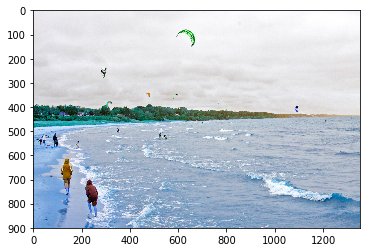

In [10]:
from matplotlib import pyplot as plt
plt.imshow(img)
plt.show()

In [11]:
dx,dy,dz= img.shape
delta=float(abs(dy-dx))
if dx > dy: #crop the x dimension
    img=img[int(0.5*delta):dx-int(0.5*delta),0:dy]
else:
    img=img[0:dx,int(0.5*delta):dy-int(0.5*delta)]
    
img = cv2.resize(img, (reqsize, reqsize))

img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

for i in range(3):
    img[:,:,i] = (img[:,:,i] - mean) * std

# Inference on the Intel Compute Stick

In [12]:
import time

print('Start download to NCS...')

starttime=time.time()
graph.queue_inference_with_fifo_elem(input_fifo, output_fifo, img.astype(numpy.float32), 'user object')

output, userobj = output_fifo.read_elem()

endtime=time.time()

print('*'*79)
print('Time taken is:',endtime-starttime)
top_inds = output.argsort()[::-1][:5]

print(''.join(['*' for i in range(79)]))
print('MobileNet on NCS')
print(''.join(['*' for i in range(79)]))
for i in range(5):
    print(top_inds[i], categories[top_inds[i]], output[top_inds[i]])
    

print(''.join(['*' for i in range(79)]))

Start download to NCS...
*******************************************************************************
Time taken is: 0.05752825736999512
*******************************************************************************
MobileNet on NCS
*******************************************************************************
972 bubble 0.60791
563 fountain 0.103943
820 stage 0.036499
815 speedboat 0.0267181
101 black swan, Cygnus atratus 0.0226746
*******************************************************************************


# Final Clean Up

In [13]:
input_fifo.destroy()
output_fifo.destroy()
graph.destroy()
device.close()
device.destroy()
print('Finished')

Finished
